### Iterative hard thresholding with unit step size

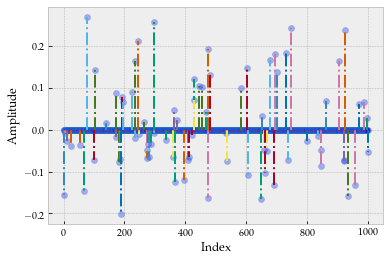

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import brewer

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import random
from numpy import linalg as la

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

p = 1000  # Ambient dimension
n = 300   # Number of samples
k = 80   # Sparsity level

# Generate a p-dimensional zero vector
x_star = np.zeros(p)
# Randomly sample k indices in the range [1:p]
x_star_ind = random.sample(range(p),  k) 
# Set x_star_ind with k random elements from Gaussian distribution
x_star[x_star_ind] = np.random.randn(k)
# Normalize
x_star = (1 / la.norm(x_star, 2)) * x_star

# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# Generate sensing matrix
Phi = (1 / math.sqrt(n)) * np.random.randn(n, p)

# Observation model
y = Phi @ x_star

In [2]:
# Hard thresholding function
def hardThreshold(x, k):
    p = x.shape[0]
    t = np.sort(np.abs(x))[::-1]    
    threshold = t[k-1]
    j = (np.abs(x) < threshold)
    x[j] = 0
    return x

# Returns the value of the objecive function
def f(y, A, x):
    return 0.5 * math.pow(la.norm(y - Phi @ x, 2), 2)

def IHT(y, A, k, eta, iters, epsilon, verbose, x_star):
    # Length of original signal
    p = A.shape[1]
    # Length of measurement vector
    n = A.shape[0]
    # Initial estimate
    x_new = np.zeros(p)    
    # Transpose of A
    At = np.transpose(A)

    # Initialize
    x_new = np.zeros(p)           # The algorithm starts at x = 0

    PhiT = np.transpose(Phi)
    
    x_list, f_list = [1], [f(y, Phi, x_new)]

    for i in range(iters):
        x_old = x_new
    
        # Compute gradient
        grad = -PhiT @ (y - Phi @ x_new)
    
        # Perform gradient step
        x_temp = x_old - eta * grad    
    
        # Perform hard thresholding step
        x_new = hardThreshold(x_temp, k)
    
        if (la.norm(x_new - x_old, 2) / la.norm(x_new, 2)) < epsilon:
            break
                
        # Keep track of solutions and objective values
        x_list.append(la.norm(x_new - x_star, 2))
        f_list.append(f(y, Phi, x_new))
        
        if verbose:
            print("iter# = "+ str(i) + ", ||x_new - x_old||_2 = " + str(la.norm(x_new - x_old, 2)))
    
    print("Number of steps:", len(f_list))
    return x_new, x_list, f_list

iter# = 0, ||x_new - x_old||_2 = 0.014608602829992063
iter# = 1, ||x_new - x_old||_2 = 0.014224554221274294
iter# = 2, ||x_new - x_old||_2 = 0.013851353457012456
iter# = 3, ||x_new - x_old||_2 = 0.013488698697012675
iter# = 4, ||x_new - x_old||_2 = 0.013136296505836288
iter# = 5, ||x_new - x_old||_2 = 0.012793861616014424
iter# = 6, ||x_new - x_old||_2 = 0.012461116697819116
iter# = 7, ||x_new - x_old||_2 = 0.012137792135408295
iter# = 8, ||x_new - x_old||_2 = 0.011823625809167342
iter# = 9, ||x_new - x_old||_2 = 0.011518362884075121
iter# = 10, ||x_new - x_old||_2 = 0.01122175560392757
iter# = 11, ||x_new - x_old||_2 = 0.010933563091256666
iter# = 12, ||x_new - x_old||_2 = 0.010653551152787879
iter# = 13, ||x_new - x_old||_2 = 0.010381492090283455
iter# = 14, ||x_new - x_old||_2 = 0.010117164516623874
iter# = 15, ||x_new - x_old||_2 = 0.009860353176984223
iter# = 16, ||x_new - x_old||_2 = 0.009610848774966542
iter# = 17, ||x_new - x_old||_2 = 0.009368447803553712
iter# = 18, ||x_new -

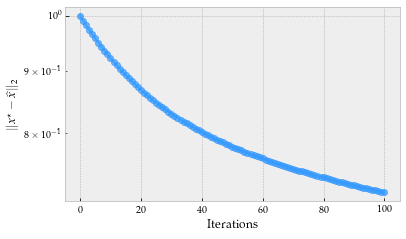

In [3]:
# Run algorithm
epsilon = 1e-6                # Precision parameter
iters = 100
eta = 0.01

x_IHT, x_list, f_list = IHT(y, Phi, k, eta, iters, epsilon, True, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs = range(len(x_list))
plt.plot(xs, x_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

### Iterative hard thresholding with unit step size

In [4]:
# Hard thresholding function
def hardThreshold2(x, k):
    p = x.shape[0]
    t = np.sort(np.abs(x))[::-1]    
    threshold = t[k-1]
    j = (np.abs(x) < threshold)
    temp = (np.abs(x) >= threshold)
    X_i = list(compress(range(len(temp)), temp))
    x[j] = 0
    return x, X_i

def adaIHT(y, A, k, iters, epsilon, verbose, x_star):
    # Length of original signal
    p = A.shape[1]
    # Length of measurement vector
    n = A.shape[0]
    # Initial estimate
    x_new = np.zeros(p)    
    # Transpose of A
    At = np.transpose(A)

    # Initialize
    x_new = np.zeros(p)           # The algorithm starts at x = 0
    X_i = []
    active_set = np.ones(p)
    
    PhiT = np.transpose(Phi)
    
    x_list, f_list = [1], [f(y, Phi, x_new)]

    for i in range(iters):
        x_old = x_new
    
        # Compute gradient    
        if (i == 0):
            grad = -PhiT @ y
        else:
            grad = -PhiT @ (y - Phi @ x_new)
    
        active_set[X_i] = 0
        grad_outside_X_i = grad * active_set
        t = np.sort(np.abs(grad_outside_X_i))[::-1]    
        threshold = t[k-1]
        j = (np.abs(grad_outside_X_i) >= threshold)
        T = list(compress(range(len(j)), j))
        Q = X_i + T
        
        # Compute step size
        eta = la.norm(grad[Q])**2 / la.norm(Phi[:, Q] @ grad[Q])**2
        
        # Perform gradient step
        x_temp = x_old - eta * grad    
    
        # Perform hard thresholding step
        x_new, X_i = hardThreshold2(x_temp, k)        
    
        if (la.norm(x_new - x_old, 2) / la.norm(x_new, 2)) < epsilon:
            break
                
        # Keep track of solutions and objective values
        x_list.append(la.norm(x_new - x_star, 2))
        f_list.append(f(y, Phi, x_new))
        
        if verbose:
            print("iter# = "+ str(i) + ", ||x_new - x_old||_2 = " + str(la.norm(x_new - x_old, 2)))
    
    print("Number of steps:", len(f_list))
    return x_new, x_list, f_list

iter# = 0, ||x_new - x_old||_2 = 0.14608602829992062
iter# = 1, ||x_new - x_old||_2 = 0.10791290047025112
iter# = 2, ||x_new - x_old||_2 = 0.08060597634983904
iter# = 3, ||x_new - x_old||_2 = 0.0611347214540725
iter# = 4, ||x_new - x_old||_2 = 0.04729916759308592
iter# = 5, ||x_new - x_old||_2 = 0.03749350340639738
iter# = 6, ||x_new - x_old||_2 = 0.030540388382192047
iter# = 7, ||x_new - x_old||_2 = 0.02557815348403008
iter# = 8, ||x_new - x_old||_2 = 0.021984225626485283
iter# = 9, ||x_new - x_old||_2 = 0.023717905341326492
iter# = 10, ||x_new - x_old||_2 = 0.01900554024429112
iter# = 11, ||x_new - x_old||_2 = 0.017200590916083846
iter# = 12, ||x_new - x_old||_2 = 0.015743028369889066
iter# = 13, ||x_new - x_old||_2 = 0.014532852285786444
iter# = 14, ||x_new - x_old||_2 = 0.01350377432362601
iter# = 15, ||x_new - x_old||_2 = 0.01261141234606384
iter# = 16, ||x_new - x_old||_2 = 0.011825486927128662
iter# = 17, ||x_new - x_old||_2 = 0.01112480827253968
iter# = 18, ||x_new - x_old||_2 

iter# = 70, ||x_new - x_old||_2 = 0.010848590946444915
iter# = 71, ||x_new - x_old||_2 = 0.008253470231073852
iter# = 72, ||x_new - x_old||_2 = 0.018480541537284546
iter# = 73, ||x_new - x_old||_2 = 0.009664609990416743
iter# = 74, ||x_new - x_old||_2 = 0.01808285024243782
iter# = 75, ||x_new - x_old||_2 = 0.010482646813760056
iter# = 76, ||x_new - x_old||_2 = 0.017444912057893832
iter# = 77, ||x_new - x_old||_2 = 0.010594528473493833
iter# = 78, ||x_new - x_old||_2 = 0.008248882887716875
iter# = 79, ||x_new - x_old||_2 = 0.006769757556082228
iter# = 80, ||x_new - x_old||_2 = 0.01650158707788518
iter# = 81, ||x_new - x_old||_2 = 0.00925111308974738
iter# = 82, ||x_new - x_old||_2 = 0.0076473769979245815
iter# = 83, ||x_new - x_old||_2 = 0.015166774545844237
iter# = 84, ||x_new - x_old||_2 = 0.015454700427727815
iter# = 85, ||x_new - x_old||_2 = 0.016298290480845922
iter# = 86, ||x_new - x_old||_2 = 0.010191448826218035
iter# = 87, ||x_new - x_old||_2 = 0.008229887401932581
iter# = 88, 

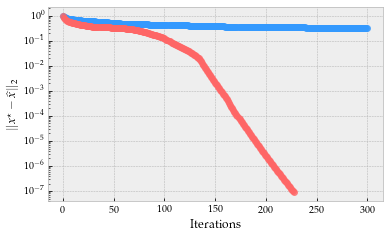

In [8]:
from itertools import compress

# Run algorithm
epsilon = 1e-8                # Precision parameter
iters = 300
eta = 0.1

x_IHT, x_list, f_list = IHT(y, Phi, k, eta, iters, epsilon, True, x_star)
x_adaIHT, x_adalist, f_adalist = adaIHT(y, Phi, k, iters, epsilon, True, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs_IHT = range(len(x_list))
xs_adaIHT = range(len(x_adalist))

plt.plot(xs_IHT, x_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.plot(xs_adaIHT, x_adalist, '-o', color = '#FF6666', linewidth = 2, alpha = 0.7)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

### Under-/Over-shooting sparsity level

In [ ]:
from itertools import compress

# Run algorithm
epsilon = 1e-8                # Precision parameter
iters = 300
eta = 0.1
k = 400

x_IHT, x_list, f_list = IHT(y, Phi, k, eta, iters, epsilon, True, x_star)
x_adaIHT, x_adalist, f_adalist = adaIHT(y, Phi, k, iters, epsilon, True, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs_IHT = range(len(x_list))
xs_adaIHT = range(len(x_adalist))

plt.plot(xs_IHT, x_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.plot(xs_adaIHT, x_adalist, '-o', color = '#FF6666', linewidth = 2, alpha = 0.7)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

In [ ]:
# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_IHT, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_adaIHT, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()
